In [ ]:
import librosa
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from random import shuffle
from tqdm.notebook import tqdm
import pandas as pd
from time import time

import pickle

from scipy.special import softmax
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#from scipy.misc import imread, imresize

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR=r'/content/drive/MyDrive/data/AudioVideo'
IMG_SIZE = 224

num_labels = 6 
emotions_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
class_to_idx = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
idx_to_class = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

In [ ]:
!pip3 install pickle5
path_to_protocol5 = '/content/drive/MyDrive/data/enet_b0_8_afew_extra.pickle'

import pickle5 as p
import pickle


with open(path_to_protocol5, "rb") as fh:
  filename2features_train, filename2features_val = p.load(fh)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 5.1 MB/s 


In [ ]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for class_name in class_to_idx:
        for filename in tqdm(os.listdir(os.path.join(data_dir,class_name))):
            fn=os.path.splitext(filename)[0] # goes through files names
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            #print(len(features))
            if True:
                if len(features[0])!=0:
                    cur_features=features[0][features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(class_to_idx[class_name])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train_enet, y_train_enet, has_faces_train = create_dataset(filename2features_train, os.path.join(DATA_DIR, 'Train_AFEW'))
x_test_enet, y_test_enet, has_faces_test = create_dataset(filename2features_val, os.path.join(DATA_DIR, 'Val_AFEW'))

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

(773, 5120) (773,)


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

(383, 5120) (383,)


In [ ]:
from sklearn import svm,metrics,preprocessing

x_train_norm=preprocessing.normalize(x_train_enet,norm='l2')
x_test_norm=preprocessing.normalize(x_test_enet,norm='l2')

In [ ]:
lin_svc = svm.LinearSVC(C=1.1) #0.5 1.1 0.6
   
lin_svc.fit(x_train_norm[has_faces_train==1], y_train_enet[has_faces_train==1])
y_pred = lin_svc.predict(x_test_norm)

print("Accuracy:",metrics.accuracy_score(y_test_enet[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test_enet, y_pred))

Accuracy: 0.5926892950391645
Complete accuracy: 0.5926892950391645


In [ ]:
linsvc_proba = []
linsvc_dist = lin_svc.decision_function(x_test_norm)
for i in range(len(linsvc_dist)):
  linsvc_proba.append(softmax(linsvc_dist[i]))

linsvc_proba = np.array(linsvc_proba)


In [ ]:
import pickle
model_name = 'linsvc'
MODEL2EMOTIW_FEATURES=model_name+'_proba_afew.pickle' 

print(MODEL2EMOTIW_FEATURES)

with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump(linsvc_proba, handle, protocol=pickle.HIGHEST_PROTOCOL)

linsvc_proba_afew.pickle


In [ ]:
rf_clf=RandomForestClassifier(n_estimators=1000,max_depth=12, n_jobs=-1, class_weight='balanced')

if True:    
    rf_clf.fit(x_train_norm[has_faces_train==1], y_train_enet[has_faces_train==1])
    y_pred = rf_clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test_enet[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test_enet, y_pred))

Accuracy: 0.5248041775456919
Complete accuracy: 0.5248041775456919


In [ ]:
rf_proba = rf_clf.predict_proba(x_test_norm)

In [ ]:
import pickle
model_name = 'rf'
MODEL2EMOTIW_FEATURES=model_name+'_proba_afew.pickle' 

print(MODEL2EMOTIW_FEATURES)

with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump(rf_proba, handle, protocol=pickle.HIGHEST_PROTOCOL)

rf_proba_afew.pickle


## Audio

In [ ]:
!pip install transformers==4.11.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 58.3 MB/s 
     |████████████████████████████████| 880 kB 61.7 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 3.3 MB 51.4 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=06b1a2c82dcd173adb57a68829a571f12cca2d5f5a3a134f04275a3b855adca8
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torchaudio
import torch
import numpy as np
from transformers import AutoConfig, Wav2Vec2Processor, AutoModelForAudioClassification

In [ ]:
model_name_or_path = "jonatasgrosman/wav2vec2-large-xlsr-53-english"
pooling_mode = "mean"
processor = Wav2Vec2Processor.from_pretrained(model_name_or_path)
target_sampling_rate = processor.feature_extractor.sampling_rate

Downloading:   0%|          | 0.00/262 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/300 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

In [ ]:
def preprocess_function_eval(speech_path):   
    speech_array, sampling_rate = librosa.load(speech_path, sr = 16000)
    result = processor(speech_array, sampling_rate=target_sampling_rate, max_length=50000, padding=True, truncation=True, return_attention_mask=True)
    len_of_input_data = result['input_values'][0].shape[0]
    padded_array = np.pad(result['input_values'][0], ((0,50000-len_of_input_data)), constant_values=0)
    return padded_array

In [ ]:
# config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id=class_to_idx,
    id2label=idx_to_class,
    finetuning_task="wav2vec2_clf",    
)
setattr(config, 'pooling_mode', pooling_mode)

In [ ]:
model = AutoModelForAudioClassification.from_pretrained(
    '/content/drive/MyDrive/models/wav2vec2/hugging_face_w2v2', 
    num_labels=6,
    label2id=class_to_idx,
    id2label=idx_to_class,
) # acc 0.415144

device = 'cuda:0'
model.to(device)

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureExtractor(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (1): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (2): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (3): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        )
        (4): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 51

In [ ]:
import pathlib 

path = pathlib.Path('/content/drive/MyDrive/data/AudioVideo/Val_AFEW_audio')

emotions_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
audio_proba = [] 

for emotion_name in emotions_list: 
  print(emotion_name)
  audio_path = path/emotion_name
  for audio in audio_path.iterdir():
    with torch.no_grad():
      input = torch.from_numpy(np.expand_dims(preprocess_function_eval(audio), 0)).to(device)
      output = model(input)
      audio_proba.append(softmax(output[0][0].cpu().numpy()))
audio_proba = np.array(audio_proba)

Angry
Disgust
Fear
Happy
Neutral
Sad
Surprise


In [ ]:
import pickle
model_name = 'w2v2'
MODEL2EMOTIW_FEATURES=model_name+'_prob_audio_afew.pickle' 

print(MODEL2EMOTIW_FEATURES)

with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump(prob_audio, handle, protocol=pickle.HIGHEST_PROTOCOL)

w2v2_prob_audio_afew.pickle


Text(151.5, 0.5, 'Actual')

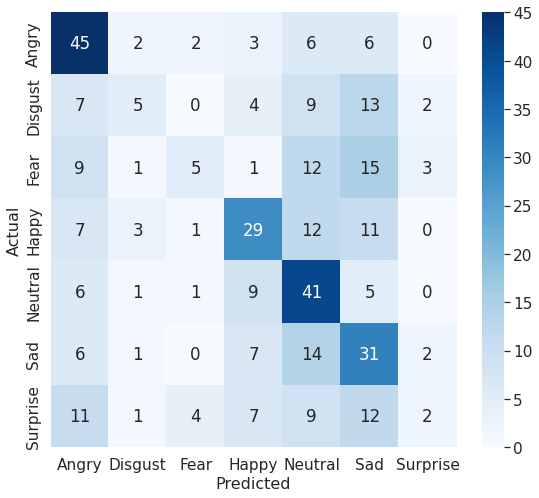

In [ ]:
y_pred = np.argmax(audio_proba, axis = 1)

classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise')

confusion = pd.crosstab(y_test_enet, y_pred, rownames=['y_true'], colnames=['y_pred'])
confusion.columns = classes
confusion.index = classes

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(121)
#ax1.set_title('Confusion matrix')
s = sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
sns.set(font_scale=1.4)
s.set_xlabel('Predicted', fontsize=16)
s.set_ylabel('Actual', fontsize=16)

## Soft Voting

In [ ]:
path_to_audio_proba = '/content/drive/MyDrive/data/w2v2_prob_audio_afew.pickle'

with open(path_to_audio_proba, "rb") as fh:
  audio_proba = p.load(fh)

In [ ]:
path_to_rf_proba = '/content/drive/MyDrive/data/rf_proba_afew.pickle'

with open(path_to_rf_proba, "rb") as fh:
  rf_proba = p.load(fh)

In [ ]:
path_to_of_proba = '/content/drive/MyDrive/data/xgb_of_afew.pickle'

with open(path_to_of_proba, "rb") as fh:
  of_proba = p.load(fh)

In [ ]:
weights = np.arange(0.05, 0.5, 0.01)
small_weights = np.arange(0, 0.05, 0.01)

best_weights = [0, 0, 0, 0]
best_acc = 0

for r in small_weights:
   for o in small_weights:
     for a in weights:
       for l in weights:
          y_pred = []
          for i in range(0, len(linsvc_proba)):
            max_prob = np.argmax(r*rf_proba[i]+o*of_proba[i]+a*audio_proba[i]+l*linsvc_proba[i])
            y_pred.append(max_prob)
          if metrics.accuracy_score(y_test_enet, np.array(y_pred)) > best_acc:
            best_acc = metrics.accuracy_score(y_test_enet, np.array(y_pred))
            best_weights[0] = r
            best_weights[1] = o
            best_weights[2] = a
            best_weights[3] = l
            print(best_acc, best_weights)

0.6266318537859008 [0.0, 0.0, 0.05, 0.05]
0.639686684073107 [0.0, 0.0, 0.060000000000000005, 0.05]
0.6449086161879896 [0.0, 0.0, 0.07, 0.05]
0.6475195822454308 [0.0, 0.0, 0.11000000000000001, 0.060000000000000005]
0.6527415143603134 [0.0, 0.01, 0.17000000000000004, 0.07]
0.6553524804177546 [0.0, 0.01, 0.19, 0.08000000000000002]
0.6579634464751958 [0.0, 0.01, 0.23000000000000004, 0.12000000000000001]
0.660574412532637 [0.01, 0.0, 0.07, 0.05]
0.6657963446475196 [0.01, 0.01, 0.15000000000000002, 0.07]
0.6684073107049608 [0.02, 0.01, 0.060000000000000005, 0.08000000000000002]
0.6710182767624021 [0.02, 0.01, 0.22000000000000003, 0.1]
0.6736292428198434 [0.03, 0.01, 0.1, 0.13]
0.6762402088772846 [0.03, 0.01, 0.25000000000000006, 0.1]
0.6788511749347258 [0.04, 0.01, 0.25000000000000006, 0.11000000000000001]


In [ ]:
weights = np.arange(0, 1, 0.01)
small_weights = [0]#np.arange(0, 0.05, 0.01)

best_weights = [0, 0, 0, 0]
best_acc = 0

for r in small_weights:
   for o in small_weights:
     for a in weights:
       for l in weights:
          y_pred = []
          for i in range(0, len(linsvc_proba)):
            max_prob = np.argmax(r*rf_proba[i]+o*of_proba[i]+a*audio_proba[i]+l*linsvc_proba[i])
            y_pred.append(max_prob)
          if metrics.accuracy_score(y_test_enet, np.array(y_pred)) > best_acc:
            best_acc = metrics.accuracy_score(y_test_enet, np.array(y_pred))
            best_weights[0] = r
            best_weights[1] = o
            best_weights[2] = a
            best_weights[3] = l
            print(best_acc, best_weights)

0.1671018276762402 [0, 0, 0.0, 0.0]
0.5926892950391645 [0, 0, 0.0, 0.01]
0.6266318537859008 [0, 0, 0.01, 0.01]
0.639686684073107 [0, 0, 0.02, 0.01]
0.6449086161879896 [0, 0, 0.03, 0.02]
0.6475195822454308 [0, 0, 0.11, 0.06]


In [ ]:
best_weights = [0.04, 0.01, 0.25000000000000006, 0.11000000000000001]

y_pred = []

for i in range(0, len(linsvc_proba)):
  y_pred.append(np.argmax(best_weights[0]*rf_proba[i]+best_weights[1]*of_proba[i]+best_weights[2]*audio_proba[i]+best_weights[3]*linsvc_proba[i]))

print("Complete accuracy:",metrics.accuracy_score(y_test_enet, np.array(y_pred)))

Complete accuracy: 0.6788511749347258


Text(151.5, 0.5, 'Actual')

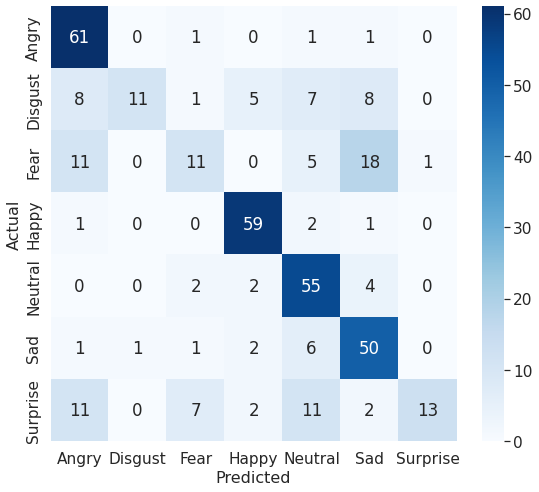

In [ ]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise')

confusion = pd.crosstab(y_test_enet, np.array(y_pred), rownames=['y_true'], colnames=['y_pred'])
confusion.columns = classes
confusion.index = classes

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(121)
#ax1.set_title('Confusion matrix')
s = sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g')
sns.set(font_scale=1.4)
s.set_xlabel('Predicted', fontsize=16)
s.set_ylabel('Actual', fontsize=16)